**Adverse Event Detection**

This notebook illustrates how adverse events related to medical products can be detected based on short texts, which potentially contain an adverse event. The task is to classify if a short text is containing an adverse event or not. The notebook is designed to run on Google Colab

We start to install all relevant dependencies:

In [ ]:
!pip install transformers

In [ ]:
!pip install accelerate -U

In [ ]:
!pip install sklearn

In [ ]:
!pip install torch

In [ ]:
!pip install datasets

You should have the file `ae_summer_school.json` located on your local machine, cf. the instructions in the README of the corresponding repository







To make this file available in the colab environment, execute


```
from google.colab import files
uploaded = files.upload()
```
and select the path to the file on your local machine


In [6]:
from google.colab import files
uploaded = files.upload()

Saving ae_summer_school.json to ae_summer_school.json


Let us write a helper function to load data from a json file and store it in a pandas dataframe

In [7]:
import pandas as pd
def get_data(json_file_name):
  df=pd.read_json(json_file_name)
  return df


Now we can load the data containing the adverse events

In [238]:
df = get_data('ae_summer_school.json')

Let us explore the dataset briefly and check if the classes are imbalanced:

In [239]:
df.head()

,sentence,adverse_event
0,The patient experienced severe abdominal pain ...,Yes
1,The laboratory test results showed no abnormal...,No
2,"The medication was well-tolerated, with no rep...",No
3,The participant developed a rash and itching a...,Yes
4,The patient suffered from dizziness and nausea...,Yes


In [240]:
df.groupby('adverse_event').size()

adverse_event
No     236
Yes    216
dtype: int64

The sentences are short and there is no class impalance.
We want to replace the Yes/No values by 1/0 and rename some of the columns since this will be required later for the training process. We write a function which is doing this:

In [241]:
def preprocessing(df):
  df['label'] = df['adverse_event'].replace({'Yes':1, 'No':0})
  df = df.rename(columns={'sentence': 'label_text'})
  return df

In [242]:
df = preprocessing(df)

In [243]:
df.head()

,label_text,adverse_event,label
0,The patient experienced severe abdominal pain ...,Yes,1
1,The laboratory test results showed no abnormal...,No,0
2,"The medication was well-tolerated, with no rep...",No,0
3,The participant developed a rash and itching a...,Yes,1
4,The patient suffered from dizziness and nausea...,Yes,1


**Training of a model to detect adverse events**

We start to split the data into a `train/val/test` set

In [244]:
import pandas as pd
from sklearn.model_selection import train_test_split

def train_test_val_split(df):
  # Split the DataFrame into train and remaining data
  df_train, df_remaining = train_test_split(df, test_size=0.3, random_state=42)

  # Split the remaining data into test and validation sets
  df_test, df_val = train_test_split(df_remaining, test_size=0.5, random_state=42)

  # Print the shapes of the resulting DataFrames
  print("Train set shape:", df_train.shape)
  print("Test set shape:", df_test.shape)
  print("Validation set shape:", df_val.shape)
  return df_train, df_val, df_test


In [245]:
df_train, df_val, df_test = train_test_val_split(df)

Train set shape: (316, 3)
Test set shape: (68, 3)
Validation set shape: (68, 3)


We want to keep the model training as simple as possible and utilize pre-trained models which incorporate already knowledge from the medical domain. This allows us to work with ‘small data’ and we don't need to design a model architecture from scratch. The pre-trained models we use are based on a BERT architecture, cf. the paper [attention is all your need](https://arxiv.org/abs/1706.03762).

In [246]:
from transformers import BertForSequenceClassification, BertTokenizer, TrainingArguments, Trainer
import torch
from datasets import Dataset
import pandas as pd
from sklearn.metrics import accuracy_score

def get_foundational_model(model_name='microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract', num_labels=2):
  # Load pre-trained model and tokenizer
  model = BertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
  tokenizer = BertTokenizer.from_pretrained(model_name)

  return tokenizer, model

In [ ]:
tokenizer, model = get_foundational_model()

We don't need to extend the model architecture of the foundational model. By providing the `num_labels` parameter, the last hidden state is feed into a fully conected layer providing logits/probabilities for the classes. Also, a loss function is already included (relative entropy based). Therefore, we are ready for training. For the model training, we will use a higher level abstraction provided by Huggingfaces `Trainer` class. Using it, we don't need to loop over epochs and batches.

Before we can start the training, we need to tokenize the training data and it is required to transfrom it into the Huggingface `Dataset` type




In [248]:
def get_dataset_encodings(df, sentence_key='label_text'):
  # convert to Dataset type
  dataset_ = Dataset.from_pandas(df)

  def encode_records(record, tokenizer=tokenizer, sentence_key=sentence_key):
    return tokenizer(record[sentence_key], truncation=True, padding=True)

  # Tokenize and encode data
  dataset_encodings = dataset_.map(encode_records, batched=True)
  return dataset_encodings



In [ ]:
dataset_train_encodings = get_dataset_encodings(df_train)
dataset_val_encodings = get_dataset_encodings(df_val)
dataset_test_encodings = get_dataset_encodings(df_test)

In [29]:
dataset_train_encodings

Dataset({
    features: ['label_text', 'adverse_event', 'label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 316
})

The encoded data of type `Dataset` contains the relevan features. For our task, the `input_ids` are important. Thes are mappings of the tokence of a given sentence to integers

Now we can define hyperparameters which we want to use during training using `TrainingArguments` class of Huggingface



In [250]:
def get_training_args(num_train_epochs=3, per_device_train_batch_size=8, per_device_eval_batch_size=8):

  training_args = TrainingArguments(
      output_dir='./results',  # Directory to save the model checkpoints
      num_train_epochs=num_train_epochs,
      per_device_train_batch_size=per_device_train_batch_size,
      per_device_eval_batch_size=per_device_eval_batch_size,
      warmup_steps=500,
      weight_decay=0.01,
      logging_dir='./logs',  # Directory for storing logs
      logging_steps=10,
      evaluation_strategy='epoch',
      save_strategy='no' # to save disc space, we don't save checkpoints
  )
  return training_args

In [251]:
args = get_training_args()

We will use accuracy as metric (since we have no class imbalance)

In [252]:
def compute_accuracy(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    accuracy = accuracy_score(labels,preds)
    return {'accuracy': accuracy}

Now we are able to create an object of the `Trainer` class
using the pre-trained model, the hyperparameters and our (encoded) training and validation data


In [253]:
def get_trainer (model=model, args=args, train_dataset=dataset_train_encodings, eval_dataset=dataset_val_encodings):
  trainer = Trainer(
      model=model,
      args=args,
      compute_metrics = compute_accuracy,
      train_dataset=train_dataset,
      eval_dataset=eval_dataset
  )
  return trainer

In [254]:
trainer = get_trainer()

Let's start the training. For each epoch iteration, we can observe the accuracy on the validation set to observe if the model is learning

In [255]:
# Fine-tune the model
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.530200,0.471696,0.926471
2,0.101200,0.079982,0.985294
3,0.025000,0.073687,0.985294


TrainOutput(global_step=120, training_loss=0.3192386798560619, metrics={'train_runtime': 364.1644, 'train_samples_per_second': 2.603, 'train_steps_per_second': 0.33, 'total_flos': 12666330649440.0, 'train_loss': 0.3192386798560619, 'epoch': 3.0})

The model was able to learn and performed very good on the validation set (99% accuracy). Let us check how the model will perform on new samples and on the test set (which has not been used for model training)

In [256]:
def get_predictions(lst_medical_observations, trainer=trainer):

  df = pd.DataFrame({'label_text': lst_medical_observations})
  encodings = get_dataset_encodings(df)
  predictions = trainer.predict(encodings)
  probabilities = torch.nn.functional.softmax(torch.tensor(predictions.predictions), dim=1)
  return probabilities


Let's check a few examples:

In [257]:
get_predictions(['I took an aspirin and got a headache'])

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

tensor([[0.0732, 0.9268]])

The model would predict an adverse event for the provided sample, this looks plausible

In [258]:
get_predictions(['The patiend was fine'])

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

tensor([[0.5474, 0.4526]])

No adverse event for this example, that's also plausible

The examples look ok, let us now check the accuracy on the test set

In [259]:
trainer.evaluate(dataset_test_encodings)

{'eval_loss': 0.0507429838180542,
 'eval_accuracy': 0.9852941176470589,
 'eval_runtime': 7.4531,
 'eval_samples_per_second': 9.124,
 'eval_steps_per_second': 1.208,
 'epoch': 3.0}

It seems that our model is performing well (also 99% accuracy on unseen data) and we want to offer it 'as a service' for detecting adverse event. Therefore, we use it on potential adverse events from another data source. The new data should be stored on your local machine with the file name `ae_summer_school_new.json`

In [48]:
from google.colab import files
uploaded = files.upload()

Saving ae_summer_school_new.json to ae_summer_school_new.json


We can use out helper function `get_data` to load the new data:

In [260]:
df_new = get_data('ae_summer_school_new.json')

In [261]:
df_new.head()

,sentence,adverse_event
0,"Just tried this new treatment, feeling like a ...",No
1,"Ugh, these meds are not my cup of tea. Can't w...",Yes
2,"No issues with the therapy, feeling energized ...",No
3,"This drug is messing with my vibe, everything ...",Yes
4,Feeling on top of the world after the treatmen...,No


The data has the same format as before and looks quite similar. The text samples are also very short. Let's do the preprocessing and make predictions and evaluate the performance. Note: in a real worl scenario the ground-truth label would not be available.

In [262]:
df_new_preprocessed = preprocessing(df_new)

As bevore, we need to tokenize the data and map the tokens to `ids` (encoding)

In [263]:
dataset_new_encodings = get_dataset_encodings(df_new_preprocessed)

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

We can use the `evaluate` method of the `trainer` object to compute the accuracy of the predictions for the new data using the `model` we have just trained, the attribute `trainer.model` contains our fine-tuned model:




In [264]:
trainer.model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [265]:
trainer.evaluate(dataset_new_encodings)

{'eval_loss': 0.39373475313186646,
 'eval_accuracy': 0.75,
 'eval_runtime': 1.8459,
 'eval_samples_per_second': 10.835,
 'eval_steps_per_second': 1.625,
 'epoch': 3.0}

The accuracy dropped from 99% to 80% (sometimes to 60%), that's a lot. Why did this happen? Let us analyse the texts a bit using words clouds and comparing the distribution of words:

In [266]:
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud
from scipy.stats import entropy
from nltk import FreqDist
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

def get_word_clouds_and_entropy(corpus1, corpus2):


  # Combine corpus 1 and corpus 2
  combined_corpus = corpus1 + corpus2

  # Tokenize the combined corpus
  tokens = [word_tokenize(sentence) for sentence in combined_corpus]

  # Compute word frequencies for combined corpus
  word_freqs = FreqDist([word for sentence in tokens for word in sentence])
  total_words = sum(word_freqs.values())

  # Compute word probabilities for combined corpus
  word_probs = {word: freq / total_words for word, freq in word_freqs.items()}

  # Compute word frequencies for corpus 1
  corpus1_word_freqs = FreqDist([word for sentence in corpus1 for word in word_tokenize(sentence)])

  # Compute word probabilities for corpus 1
  corpus1_word_probs = {word: freq / len(corpus1) for word, freq in corpus1_word_freqs.items()}

  # Compute word frequencies for corpus 2
  corpus2_word_freqs = FreqDist([word for sentence in corpus2 for word in word_tokenize(sentence)])

  # Compute word probabilities for corpus 2
  corpus2_word_probs = {word: freq / len(corpus2) for word, freq in corpus2_word_freqs.items()}

  # Find common vocabulary
  common_vocab = set(corpus1_word_probs.keys()).intersection(corpus2_word_probs.keys())

  # Compute relative entropy (Kullback-Leibler divergence) for common vocabulary
  relative_entropy = entropy([corpus1_word_probs[word] for word in common_vocab], [corpus2_word_probs[word] for word in common_vocab])
  print("Relative Entropy:", relative_entropy)

  # Plot word cloud for corpus 1
  corpus1_word_cloud = WordCloud().generate_from_frequencies(corpus1_word_probs)
  plt.imshow(corpus1_word_cloud, interpolation="bilinear")
  plt.title("Word Cloud - Corpus 1")
  plt.axis("off")
  plt.show()

  # Plot word cloud for corpus 2
  corpus2_word_cloud = WordCloud().generate_from_frequencies(corpus2_word_probs)
  plt.imshow(corpus2_word_cloud, interpolation="bilinear")
  plt.title("Word Cloud - Corpus 2")
  plt.axis("off")
  plt.show()

  return relative_entropy

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [267]:
corpus_training = list(df_train['label_text'])
corpus_test = list(df_test['label_text'])
corpus_val = list(df_val['label_text'])
corpus_new = list(df_new_preprocessed['label_text'])

Relative Entropy: 0.061241883063787514


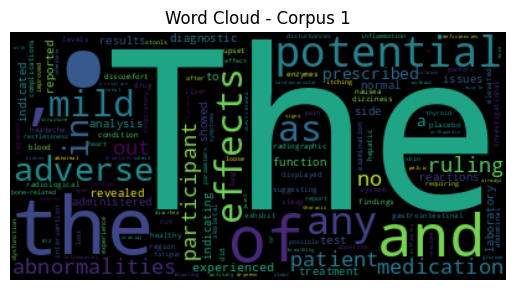

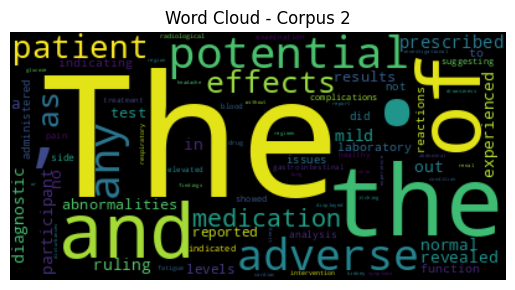

In [268]:
rel_entropy_train_test=get_word_clouds_and_entropy(corpus_training, corpus_test)

The word clouds looks comparable and the relative entropy is very low. That indicates that we have tested the model on a dataset which is comming from the same distribution as the training data

Relative Entropy: 0.4757793695470613


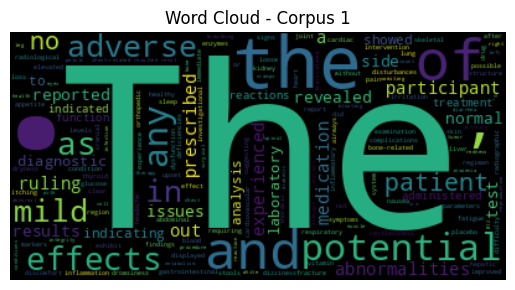

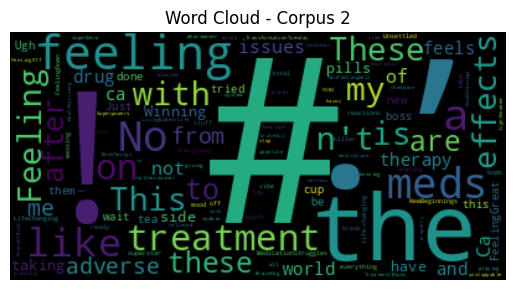

In [269]:
rel_entropy_train_new=get_word_clouds_and_entropy(corpus_training, corpus_new)

We see # and ! in the word cloud. That's something we would not expect to see in medical notes written by a healthcare professional. Also, the entropy is much higher which indicates that the new data is comming from a different probability distribution. Maybe tweets?

Relative Entropy: 0.09310786116359293


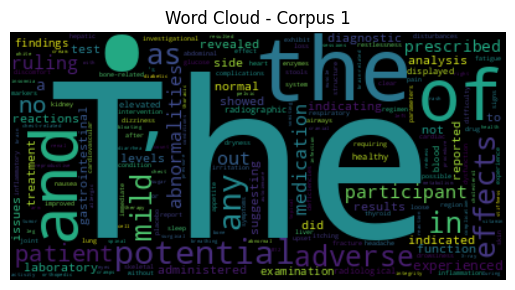

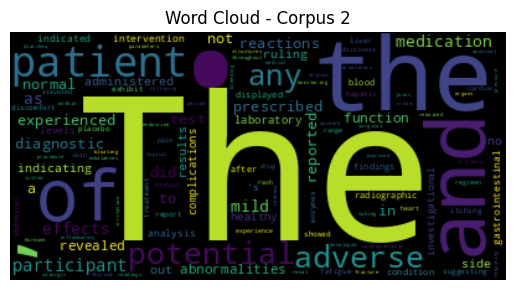

In [270]:
rel_entropy_train_val=get_word_clouds_and_entropy(corpus_training, corpus_val)

Relative Entropy: 0.06142127179213024


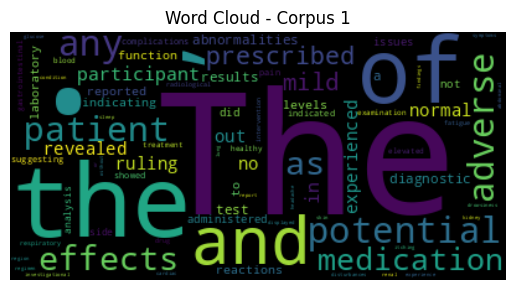

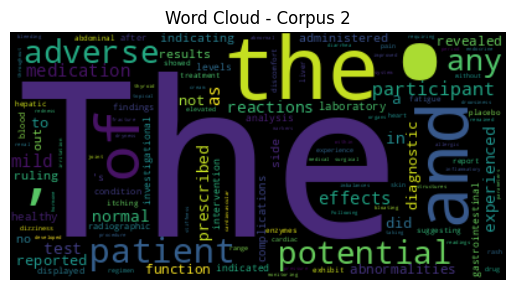

In [271]:
rel_entropy_test_val=get_word_clouds_and_entropy(corpus_test, corpus_val)

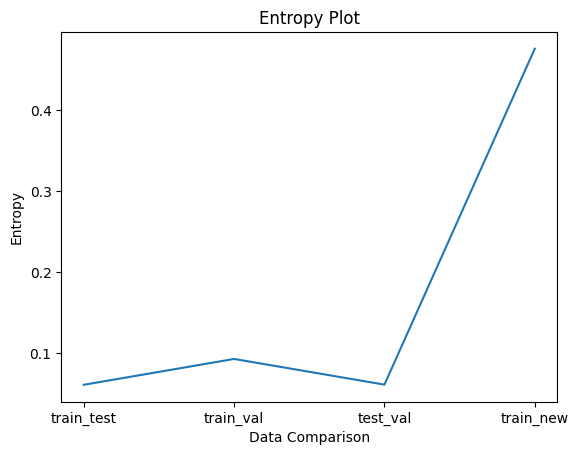

In [272]:
import matplotlib.pyplot as plt

def plot_entropy(data_comparison, entropy):
    plt.plot(data_comparison, entropy)
    plt.xlabel('Data Comparison')
    plt.ylabel('Entropy')
    plt.title('Entropy Plot')

    # Set custom x-axis tick labels
    plt.xticks(range(len(data_comparison)), data_comparison)

    plt.show()

# Example usage
data_comparison = ['train_test', 'train_val', 'test_val','train_new']
entropy = [rel_entropy_train_test, rel_entropy_train_val, rel_entropy_test_val, rel_entropy_train_new]

plot_entropy(data_comparison, entropy)


Alternative: detecting drift using a binary classifier

In [273]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

def train_classifier(corpus, new_data):
    # Combine corpus and new data
    data = corpus + new_data

    # Assign labels (0 for corpus, 1 for new data)
    labels = [0] * len(corpus) + [1] * len(new_data)

    # Vectorize the text data
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(data)

    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

    # Train a binary classifier
    classifier = LogisticRegression()
    classifier.fit(X_train, y_train)

    # Evaluate the classifier on the test set
    accuracy = classifier.score(X_test, y_test)
    print("Classifier Accuracy:", accuracy)

    return classifier, vectorizer



In [274]:
corpus = corpus_training
new_data = corpus_new

# Train the classifier on the corpus and new data
classifier, vectorizer = train_classifier(corpus, new_data)

Classifier Accuracy: 1.0


In [275]:
corpus = corpus_training
new_data = corpus_test

# Train the classifier on the corpus and new data
classifier, vectorizer = train_classifier(corpus, new_data)

Classifier Accuracy: 0.8051948051948052


**Key observation:**

If the model is used in a real world scenarion, we need a continous monitoring system which alerts us if there are signals that indicate that the model quality is getting worse.

**Ideas to fix the issue**

We have seen that the model has been used for infernce on tweet data but it has not seen such data at trining time. Maybe we can simulate tweets already at training time to be prepared once they arrive? Let us use generative AI to generate such data. We can use the OpenAP-API to interact with chatGPT programatically. Please create an account at this [webpage](https://auth0.openai.com/u/signup/identifier?state=hKFo2SBQZFNLUEpKdzMzVndLM0tlLVFiUXRXSVh4OHI3U3g2a6Fur3VuaXZlcnNhbC1sb2dpbqN0aWTZIHVxejl4UlFOVEpYS2tva2x2em1lSmdNMEF4Q25zbVJzo2NpZNkgRFJpdnNubTJNdTQyVDNLT3BxZHR3QjNOWXZpSFl6d0Q) and generate an API key. Store the key in file with the name ```config.ini``` following the structure below:

```
[API]
key = <your key>
```
Next, we need to upload this file into our colab environment.

In [76]:
from google.colab import files
uploaded = files.upload()

Saving config.ini to config.ini


Now we are able to read the api-key from the config file and use the key for authentication at OpenAI

In [276]:
import configparser

# Read the API key from the configuration file
def read_api_key(file_path):
    config = configparser.ConfigParser()
    config.read(file_path)
    api_key = config.get('API', 'key')
    return api_key

In [277]:
api_key = read_api_key('config.ini')

We need to execute `!pip install openai` to use the services provided by OpenAI:

In [ ]:
!pip install openai

In [278]:
# Import the openai package
import openai
openai.api_key=api_key

Let us have a look at a few samples of the tweets data which is stored in ```df_new```. Maybe we can use an instruction based model and using a few examples (few-shot learning) of tweets to generate new ones which we can use for model training?

In [279]:
tweet_samples=df_new[['sentence', 'label']][0:10].to_dict()

In [280]:
tweet_samples

{'sentence': {0: 'Just tried this new treatment, feeling like a boss! #FeelingGreat',
  1: "Ugh, these meds are not my cup of tea. Can't wait to be done with them. #MedicationStruggles",
  2: 'No issues with the therapy, feeling energized and ready to take on the world! #LifeChanging',
  3: 'This drug is messing with my vibe, everything feels off. #Unsettled',
  4: 'Feeling on top of the world after the treatment! #NewBeginnings',
  5: "These meds are a total mood killer, can't catch a break. #FeelingDown",
  6: 'No adverse reactions to the meds, feeling like a superstar! #Winning',
  7: 'This treatment is the bomb, life-changing stuff! #TransformationTuesday',
  8: 'These pills are wreaking havoc on my system, not cool. #FeelingOff',
  9: 'No side effects from the therapy, feeling like a rockstar! #HealthyLiving'},
 'label': {0: 0, 1: 1, 2: 0, 3: 1, 4: 0, 5: 1, 6: 0, 7: 0, 8: 1, 9: 0}}

**Prompt Engineering**

We can try to realizing our idea of few-shot learning by using prompt engineering techniques

In [281]:
prompt_template = f"""
Please analyse the following dataset given as a JSON where the key 'sentence' is describing a medical event and the key label is indicating if the event is an adverse event or not':
{tweet_samples}
Instruction :
Generate 10 records which are comparable but different to the records provided to you. The output format should be of exact the same json format as the provided data.
Your output should consist only of the JSON and nothing else!
"""

In [282]:
print(prompt_template)


Please analyse the following dataset given as a JSON where the key 'sentence' is describing a medical event and the key label is indicating if the event is an adverse event or not':
{'sentence': {0: 'Just tried this new treatment, feeling like a boss! #FeelingGreat', 1: "Ugh, these meds are not my cup of tea. Can't wait to be done with them. #MedicationStruggles", 2: 'No issues with the therapy, feeling energized and ready to take on the world! #LifeChanging', 3: 'This drug is messing with my vibe, everything feels off. #Unsettled', 4: 'Feeling on top of the world after the treatment! #NewBeginnings', 5: "These meds are a total mood killer, can't catch a break. #FeelingDown", 6: 'No adverse reactions to the meds, feeling like a superstar! #Winning', 7: 'This treatment is the bomb, life-changing stuff! #TransformationTuesday', 8: 'These pills are wreaking havoc on my system, not cool. #FeelingOff', 9: 'No side effects from the therapy, feeling like a rockstar! #HealthyLiving'}, 'label'

We can write a function which uses a prompt and generates an answer based on  the instruction based model ```gpt-3.5-turbo```

In [283]:
import openai

def generate_chat_response(prompt):
    response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": prompt},
        ],
        temperature=0.2,
        max_tokens=2000,
    )

    output = response["choices"][0]["message"]["content"]
    return output


Token and rate limits are a challenge, therefore we need a workaround to generate samples

In [284]:
def transform_output_to_dataframe(output):
  output_df = pd.DataFrame(eval(output))
  return output_df

In [285]:
import time
dict_output_df = {}
for i in range(1,10):
  time.sleep(10)
  output = generate_chat_response(prompt_template)
  dict_output_df[i] = transform_output_to_dataframe(output)

In [286]:
dict_output_df[1]

,sentence,label
0,"Just started this new treatment, feeling amazi...",0
1,"These meds are not working for me, can't wait ...",1
2,"No problems with the therapy, feeling invigora...",0
3,"This drug is affecting my mood, everything fee...",1
4,Feeling fantastic after the treatment! #NewBeg...,0
5,"These meds are really bringing me down, can't ...",1
6,"No adverse reactions to the medication, feelin...",0
7,"This treatment is incredible, life-altering st...",0
8,"These pills are causing chaos in my system, no...",1
9,"No side effects from the therapy, feeling like...",0


In [287]:
generated_samples = pd.concat(list(dict_output_df.values()))

In [288]:
generated_samples.head()

,sentence,label
0,"Just started this new treatment, feeling amazi...",0
1,"These meds are not working for me, can't wait ...",1
2,"No problems with the therapy, feeling invigora...",0
3,"This drug is affecting my mood, everything fee...",1
4,Feeling fantastic after the treatment! #NewBeg...,0


Let us do a new training run where we now include the generated data. Firs we need to assure that the 'old' training data and the generated data have the same column names:

In [289]:
generated_samples.rename(columns={'sentence': 'label_text'}, inplace=True)

Now we can consider the union of the 'old' and the generated data to get a new training data:

In [290]:
df_gen_and_old = pd.concat([generated_samples, df[['label_text', 'label']]])

We need to shuffle the data:

In [291]:
df_gen_and_old_shuffled=df_gen_and_old.sample(frac=1).reset_index(drop=True)

We are now able to start the training process again:

In [292]:
df_train, df_val, df_test = train_test_val_split(df_gen_and_old_shuffled)

Train set shape: (379, 2)
Test set shape: (81, 2)
Validation set shape: (82, 2)


We could start training from scratch or use the existing model as checkpoint and further fine-tine it

In [ ]:
#tokenizer, model = get_foundational_model()

In [293]:
dataset_train_encodings = get_dataset_encodings(df_train)
dataset_val_encodings = get_dataset_encodings(df_val)
dataset_test_encodings = get_dataset_encodings(df_test)

Map:   0%|          | 0/379 [00:00<?, ? examples/s]

Map:   0%|          | 0/82 [00:00<?, ? examples/s]

Map:   0%|          | 0/81 [00:00<?, ? examples/s]

In [294]:
args = get_training_args()

In [295]:
trainer = get_trainer(model=trainer.model, args=args, train_dataset=dataset_train_encodings, eval_dataset=dataset_val_encodings)

In [296]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.053800,0.132640,0.975610
2,0.001700,0.154896,0.975610
3,0.000500,0.210606,0.963415


TrainOutput(global_step=144, training_loss=0.04582707391657297, metrics={'train_runtime': 465.986, 'train_samples_per_second': 2.44, 'train_steps_per_second': 0.309, 'total_flos': 15775871657220.0, 'train_loss': 0.04582707391657297, 'epoch': 3.0})

Let us check if we still have poor performance on the tweets data which is contained in `df_new` and the features are in `dataset_new_encodings`:

In [298]:
trainer.evaluate(dataset_new_encodings)

{'eval_loss': 0.0024583605118095875,
 'eval_accuracy': 1.0,
 'eval_runtime': 2.9314,
 'eval_samples_per_second': 6.823,
 'eval_steps_per_second': 1.023,
 'epoch': 3.0}

In [299]:
trainer.evaluate(dataset_test_encodings)

{'eval_loss': 0.0002626560162752867,
 'eval_accuracy': 1.0,
 'eval_runtime': 12.7734,
 'eval_samples_per_second': 6.341,
 'eval_steps_per_second': 0.861,
 'epoch': 3.0}

What if we start training from scratch?

In [ ]:
tokenizer, model = get_foundational_model()

In [301]:
trainer = get_trainer(model=model, args=args, train_dataset=dataset_train_encodings, eval_dataset=dataset_val_encodings)

In [302]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.562900,0.455555,0.865854
2,0.095400,0.172242,0.939024
3,0.003800,0.280026,0.951220


TrainOutput(global_step=144, training_loss=0.30456227630687255, metrics={'train_runtime': 486.7774, 'train_samples_per_second': 2.336, 'train_steps_per_second': 0.296, 'total_flos': 15775871657220.0, 'train_loss': 0.30456227630687255, 'epoch': 3.0})

In [305]:
trainer.evaluate(dataset_new_encodings)

{'eval_loss': 0.003085693810135126,
 'eval_accuracy': 1.0,
 'eval_runtime': 2.9552,
 'eval_samples_per_second': 6.768,
 'eval_steps_per_second': 1.015,
 'epoch': 3.0}